In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [3]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

In [4]:
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

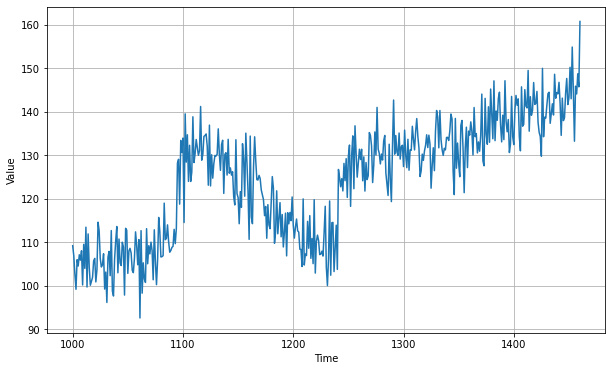

In [5]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [7]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [8]:
baseline_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

baseline_model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9), metrics=["mae"])
baseline_model.fit(dataset, epochs=100, verbose=1)

Epoch 1/100
31/31 [==============================] - 0s 9ms/step - loss: 1013.0894 - mae: 19.7440
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 63.7051 - mae: 6.0335
Epoch 3/100
31/31 [==============================] - ETA: 0s - loss: 52.3541 - mae: 5.47 - 0s 6ms/step - loss: 53.5941 - mae: 5.5088
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 52.2241 - mae: 5.4176
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 51.9443 - mae: 5.4241
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 52.5344 - mae: 5.4269
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 51.6278 - mae: 5.4222
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 53.2828 - mae: 5.5051
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 50.7910 - mae: 5.3609
Epoch 10/100
31/31 [==============================] - 0s 11ms/step - loss: 50.5795 - mae: 5.3517
Epoch 1

31/31 [==============================] - 0s 11ms/step - loss: 36.5507 - mae: 4.6893
Epoch 86/100
31/31 [==============================] - 0s 9ms/step - loss: 35.8803 - mae: 4.6643
Epoch 87/100
31/31 [==============================] - 0s 9ms/step - loss: 36.7392 - mae: 4.7124
Epoch 88/100
31/31 [==============================] - 0s 6ms/step - loss: 35.6397 - mae: 4.6221
Epoch 89/100
31/31 [==============================] - 0s 7ms/step - loss: 35.5890 - mae: 4.6292
Epoch 90/100
31/31 [==============================] - 0s 8ms/step - loss: 36.1065 - mae: 4.6526
Epoch 91/100
31/31 [==============================] - 0s 8ms/step - loss: 36.4404 - mae: 4.6795
Epoch 92/100
31/31 [==============================] - 0s 4ms/step - loss: 35.5620 - mae: 4.6413
Epoch 93/100
31/31 [==============================] - 0s 10ms/step - loss: 35.9261 - mae: 4.6577
Epoch 94/100
31/31 [==============================] - 0s 6ms/step - loss: 35.4957 - mae: 4.6168
Epoch 95/100
31/31 [==============================]

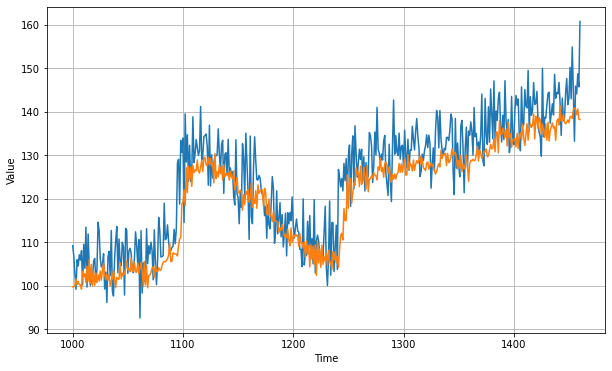

In [9]:
baseline_forecast = []
for time in range(len(series) - window_size):
    baseline_forecast.append(baseline_model.predict(series[time:time + window_size][np.newaxis]))

baseline_forecast = baseline_forecast[split_time-window_size:]
baseline_results = np.array(baseline_forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, baseline_results)

In [10]:
tf.keras.metrics.mean_absolute_error(x_valid, baseline_results).numpy()

5.623255

In [11]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [12]:
# tuning_lr_model = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
#     tf.keras.layers.Dense(10, activation="relu"), 
#     tf.keras.layers.Dense(1)
# ])

# tuning_lr_optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
# tuning_lr_model.compile(loss="mse", optimizer=tuning_lr_optimizer)
# tuning_lr_history = tuning_lr_model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=1)


tuning_lr_model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

tuning_lr_optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
tuning_lr_model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tuning_lr_optimizer,
              metrics=["mae"])
tuning_lr_history = tuning_lr_model.fit(dataset, epochs=100, callbacks=[lr_schedule])


# tuning_lr_model = tf.keras.models.Sequential([
#     tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                       input_shape=[None]),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#     tf.keras.layers.Dense(1),
#     tf.keras.layers.Lambda(lambda x: x * 100.0)
# ])

# tuning_lr_optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
# tuning_lr_model.compile(loss=tf.keras.losses.Huber(),
#               optimizer=tuning_lr_optimizer,
#               metrics=["mae"])
# tuning_lr_history = tuning_lr_model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 6ms/step - loss: 115.4981 - mae: 115.9981
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 100.7674 - mae: 101.2674
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 84.4813 - mae: 84.9813
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 69.6450 - mae: 70.1450
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 56.8126 - mae: 57.3126
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 45.3726 - mae: 45.8726
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 34.6874 - mae: 35.1873
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 24.9363 - mae: 25.4321
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 18.5180 - mae: 19.0075
Epoch 10/100
31/31 [==============================] - 0s 6ms/step - loss: 15.6812 - mae: 16.1715
Epoch 11/100
31/31 [===============

31/31 [==============================] - 0s 5ms/step - loss: 25.0010 - mae: 25.4976
Epoch 87/100
31/31 [==============================] - 0s 5ms/step - loss: 26.2132 - mae: 26.7094
Epoch 88/100
31/31 [==============================] - 0s 6ms/step - loss: 26.7103 - mae: 27.2055
Epoch 89/100
31/31 [==============================] - 0s 5ms/step - loss: 26.2721 - mae: 26.7688
Epoch 90/100
31/31 [==============================] - 0s 6ms/step - loss: 27.2736 - mae: 27.7698
Epoch 91/100
31/31 [==============================] - 0s 6ms/step - loss: 24.5055 - mae: 25.0023
Epoch 92/100
31/31 [==============================] - 0s 6ms/step - loss: 24.5965 - mae: 25.0947
Epoch 93/100
31/31 [==============================] - 0s 5ms/step - loss: 27.1232 - mae: 27.6192
Epoch 94/100
31/31 [==============================] - 0s 5ms/step - loss: 27.0840 - mae: 27.5813
Epoch 95/100
31/31 [==============================] - 0s 5ms/step - loss: 30.7359 - mae: 31.2324
Epoch 96/100
31/31 [=======================

(1e-08, 0.0001, 0.0, 30.0)

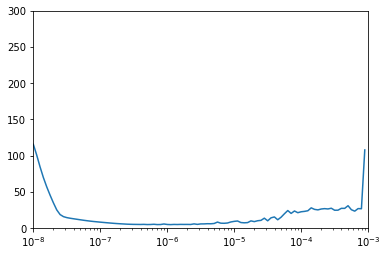

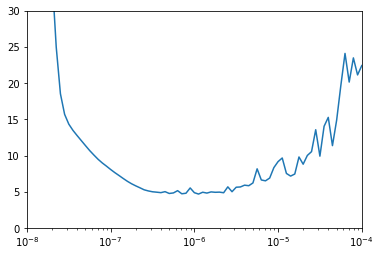

In [13]:
plt.semilogx(tuning_lr_history.history["lr"], tuning_lr_history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])
plt.figure()

plt.semilogx(tuning_lr_history.history["lr"], tuning_lr_history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [14]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [15]:
# tuned_lr_model = tf.keras.models.Sequential([
#   tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
#   tf.keras.layers.Dense(10, activation="relu"),
#   tf.keras.layers.Dense(1)
# ])

# tuned_lr_optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
# tuned_lr_model.compile(loss="mse", optimizer=tuned_lr_optimizer, metrics=["mae"])
# tuned_lr_history = tuned_lr_model.fit(dataset, epochs=500)


tuned_lr_model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

tuned_lr_optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
tuned_lr_model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tuned_lr_optimizer,
              metrics=["mae"])
tuned_lr_history = tuned_lr_model.fit(dataset, epochs=400)


# tuned_lr_model = tf.keras.models.Sequential([
#     tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                       input_shape=[None]),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#     tf.keras.layers.Dense(1),
#     tf.keras.layers.Lambda(lambda x: x * 100.0)
# ])

# tuned_lr_model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9), metrics=["mae"])
# tuned_lr_history = tuned_lr_model.fit(dataset, epochs=500)

Epoch 1/400
31/31 [==============================] - 0s 8ms/step - loss: 40.3038 - mae: 40.8011
Epoch 2/400
31/31 [==============================] - 0s 8ms/step - loss: 18.9615 - mae: 19.4554
Epoch 3/400
31/31 [==============================] - 0s 8ms/step - loss: 23.5110 - mae: 24.0084
Epoch 4/400
31/31 [==============================] - 0s 8ms/step - loss: 20.6464 - mae: 21.1411
Epoch 5/400
31/31 [==============================] - 0s 7ms/step - loss: 22.0863 - mae: 22.5825
Epoch 6/400
31/31 [==============================] - 0s 8ms/step - loss: 21.5422 - mae: 22.0388
Epoch 7/400
31/31 [==============================] - 0s 7ms/step - loss: 23.0940 - mae: 23.5915
Epoch 8/400
31/31 [==============================] - 0s 7ms/step - loss: 22.7819 - mae: 23.2778
Epoch 9/400
31/31 [==============================] - 0s 8ms/step - loss: 23.1174 - mae: 23.6136
Epoch 10/400
31/31 [==============================] - 0s 7ms/step - loss: 23.2278 - mae: 23.7235
Epoch 11/400
31/31 [===================

31/31 [==============================] - 0s 7ms/step - loss: 4.8391 - mae: 5.3157
Epoch 87/400
31/31 [==============================] - 0s 8ms/step - loss: 5.4136 - mae: 5.8964
Epoch 88/400
31/31 [==============================] - 0s 8ms/step - loss: 5.5551 - mae: 6.0385
Epoch 89/400
31/31 [==============================] - 0s 7ms/step - loss: 5.7927 - mae: 6.2768
Epoch 90/400
31/31 [==============================] - 0s 8ms/step - loss: 5.1108 - mae: 5.5908
Epoch 91/400
31/31 [==============================] - 0s 7ms/step - loss: 5.4935 - mae: 5.9766
Epoch 92/400
31/31 [==============================] - 0s 8ms/step - loss: 5.0436 - mae: 5.5230
Epoch 93/400
31/31 [==============================] - 0s 7ms/step - loss: 4.7487 - mae: 5.2279
Epoch 94/400
31/31 [==============================] - 0s 8ms/step - loss: 6.4143 - mae: 6.9005
Epoch 95/400
31/31 [==============================] - 0s 8ms/step - loss: 6.1502 - mae: 6.6288
Epoch 96/400
31/31 [==============================] - 0s 8ms/st

31/31 [==============================] - 0s 8ms/step - loss: 4.7511 - mae: 5.2276
Epoch 172/400
31/31 [==============================] - 0s 8ms/step - loss: 5.0063 - mae: 5.4890
Epoch 173/400
31/31 [==============================] - 0s 8ms/step - loss: 4.5163 - mae: 4.9951
Epoch 174/400
31/31 [==============================] - 0s 8ms/step - loss: 4.7700 - mae: 5.2503
Epoch 175/400
31/31 [==============================] - 0s 8ms/step - loss: 4.9871 - mae: 5.4702
Epoch 176/400
31/31 [==============================] - 0s 7ms/step - loss: 4.9600 - mae: 5.4374
Epoch 177/400
31/31 [==============================] - 0s 8ms/step - loss: 5.1845 - mae: 5.6626
Epoch 178/400
31/31 [==============================] - 0s 7ms/step - loss: 5.1256 - mae: 5.6064
Epoch 179/400
31/31 [==============================] - 0s 7ms/step - loss: 5.4572 - mae: 5.9385
Epoch 180/400
31/31 [==============================] - 0s 7ms/step - loss: 4.7497 - mae: 5.2291
Epoch 181/400
31/31 [==============================] -

31/31 [==============================] - 0s 7ms/step - loss: 5.2374 - mae: 5.7235
Epoch 257/400
31/31 [==============================] - 0s 7ms/step - loss: 4.3159 - mae: 4.7931
Epoch 258/400
31/31 [==============================] - 0s 7ms/step - loss: 4.7398 - mae: 5.2182
Epoch 259/400
31/31 [==============================] - 0s 8ms/step - loss: 4.8142 - mae: 5.2906
Epoch 260/400
31/31 [==============================] - 0s 8ms/step - loss: 4.0723 - mae: 4.5468
Epoch 261/400
31/31 [==============================] - 0s 7ms/step - loss: 4.3706 - mae: 4.8481
Epoch 262/400
31/31 [==============================] - 0s 8ms/step - loss: 4.1224 - mae: 4.5951
Epoch 263/400
31/31 [==============================] - 0s 7ms/step - loss: 4.5836 - mae: 5.0641
Epoch 264/400
31/31 [==============================] - 0s 8ms/step - loss: 4.6597 - mae: 5.1374
Epoch 265/400
31/31 [==============================] - 0s 8ms/step - loss: 4.8213 - mae: 5.2986
Epoch 266/400
31/31 [==============================] -

31/31 [==============================] - 0s 7ms/step - loss: 4.3251 - mae: 4.8010
Epoch 341/400
31/31 [==============================] - 0s 9ms/step - loss: 4.1966 - mae: 4.6718
Epoch 342/400
31/31 [==============================] - 0s 7ms/step - loss: 4.8575 - mae: 5.3372
Epoch 343/400
31/31 [==============================] - 0s 7ms/step - loss: 4.4691 - mae: 4.9475
Epoch 344/400
31/31 [==============================] - 0s 7ms/step - loss: 4.1109 - mae: 4.5857
Epoch 345/400
31/31 [==============================] - 0s 7ms/step - loss: 6.2977 - mae: 6.7801
Epoch 346/400
31/31 [==============================] - 0s 7ms/step - loss: 6.2354 - mae: 6.7201
Epoch 347/400
31/31 [==============================] - 0s 9ms/step - loss: 4.4686 - mae: 4.9435
Epoch 348/400
31/31 [==============================] - 0s 7ms/step - loss: 4.4183 - mae: 4.8935
Epoch 349/400
31/31 [==============================] - 0s 7ms/step - loss: 4.4165 - mae: 4.8942
Epoch 350/400
31/31 [==============================] -

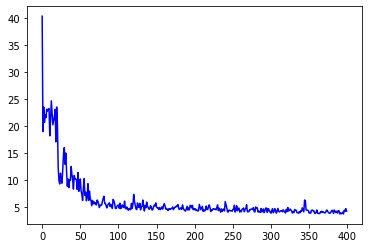

In [16]:
loss = tuned_lr_history.history["loss"]
epochs = range(len(loss))
plt.plot(epochs, loss, "b", label="Training Loss")
plt.show()

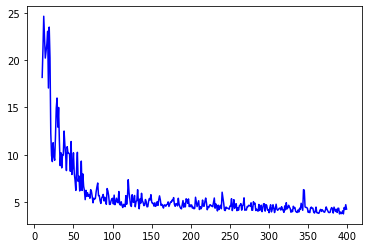

In [17]:
# Plot all but the first 10
loss = tuned_lr_history.history["loss"]
epochs = range(10, len(loss))
plt.plot(epochs, loss[10:], "b", label="Training Loss")
plt.show()

<Figure size 432x288 with 0 Axes>

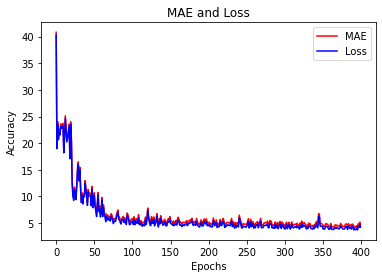

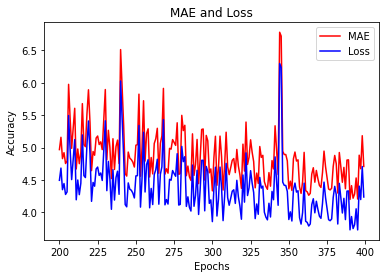

<Figure size 432x288 with 0 Axes>

In [18]:
mae = tuned_lr_history.history["mae"]
loss = tuned_lr_history.history["loss"]

mae_zoom = mae[200:]
loss_zoom = loss[200:]

epochs = range(len(loss)) # Get number of epochs
epochs_zoom = epochs[200:]

plt.plot(epochs, mae, "r")
plt.plot(epochs, loss, "b")
plt.title("MAE and Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

plt.plot(epochs_zoom, mae_zoom, "r")
plt.plot(epochs_zoom, loss_zoom, "b")
plt.title("MAE and Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()